In [1]:
import numpy as np
import pandas as pd
pd.options.plotting.backend = "plotly"
import random
from glob import glob
import os, shutil
from tqdm.notebook import tqdm
tqdm.pandas()
import time
import copy
import joblib
import gc
from IPython import display as ipd
from joblib import Parallel, delayed

# visualization
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import tensorflow as tf

IMG_SIZE = [320, 384]

def load_img(path, size=IMG_SIZE):
    img = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    shape0 = np.array(img.shape[:2])
    resize = np.array(size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        img = np.pad(img, [pady, padx])
        img = img.reshape((*resize))
        
#     img = np.tile(img[...,None], [1, 1, 3]) # gray to rgb
#     img = img.astype('float32') # original is uint16
#     mx = np.max(img)
#     if mx:
#         img/=mx # scale image to [0, 1]
    return img

def load_msk(path, size=IMG_SIZE):
    msk = np.load(path)
#     msk = msk.astype('float32')
#     msk/=255.0
#     msk = cv2.resize(msk, dsize=size, interpolation=cv2.INTER_NEAREST)
    shape0 = np.array(msk.shape[:2])
    resize = np.array(size)
    if np.any(shape0!=resize):
        diff = resize - shape0
        pad0 = diff[0]
        pad1 = diff[1]
        pady = [pad0//2, pad0//2 + pad0%2]
        padx = [pad1//2, pad1//2 + pad1%2]
        msk = np.pad(msk, [pady, padx, [0,0]])
        msk = msk.reshape((*resize, 3))
    return msk

def show_img(img, mask=None):
    plt.imshow(img, cmap='bone')
    
    if mask is not None:
        # plt.imshow(np.ma.masked_where(mask!=1, mask), alpha=0.5, cmap='autumn')
        plt.imshow(mask, alpha=0.5)
        handles = [Rectangle((0,0),1,1, color=_c) for _c in [(0.667,0.0,0.0), (0.0,0.667,0.0), (0.0,0.0,0.667)]]
        labels = [ "Large Bowel", "Small Bowel", "Stomach"]
        plt.legend(handles,labels)
    plt.axis('off')
    
def load_imgs(img_paths, size=IMG_SIZE):
    imgs = np.zeros((*size, len(img_paths)), dtype=np.uint16)
    for i, img_path in enumerate(img_paths):
        img = load_img(img_path, size=size)
        imgs[..., i]+=img
    return imgs

In [2]:
df = pd.read_csv('/home/yiw/gi/train_step0.csv')
df['segmentation'] = df.segmentation.fillna('')
df['rle_len'] = df.segmentation.map(len) # length of each rle mask
df['mask_path'] = df.mask_path.str.replace('/png/','/np/').str.replace('.png','.npy')

df2 = df.groupby(['id'])['segmentation'].agg(list).to_frame().reset_index() # rle list of each id
df2 = df2.merge(df.groupby(['id'])['rle_len'].agg(sum).to_frame().reset_index()) # total length of all rles of each id

df = df.drop(columns=['segmentation', 'class', 'rle_len'])
df = df.groupby(['id']).head(1).reset_index(drop=True)
df = df.merge(df2, on=['id'])
df['empty'] = (df.rle_len==0) # empty masks
df.head(199)

<ipython-input-2-d990053b069b>:4: FutureWarning: The default value of regex will change from True to False in a future version.
  df['mask_path'] = df.mask_path.str.replace('/png/','/np/').str.replace('.png','.npy')


,id,case,day,slice,image_path,height,width,mask_path,segmentation,rle_len,empty
0,case123_day20_slice_0001,123,20,1,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
1,case123_day20_slice_0002,123,20,2,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
2,case123_day20_slice_0003,123,20,3,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
3,case123_day20_slice_0004,123,20,4,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
4,case123_day20_slice_0005,123,20,5,/home/yiw/gi/input/train/case123/case123_day20...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
...,...,...,...,...,...,...,...,...,...,...,...
194,case123_day22_slice_0051,123,22,51,/home/yiw/gi/input/train/case123/case123_day22...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
195,case123_day22_slice_0052,123,22,52,/home/yiw/gi/input/train/case123/case123_day22...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
196,case123_day22_slice_0053,123,22,53,/home/yiw/gi/input/train/case123/case123_day22...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True
197,case123_day22_slice_0054,123,22,54,/home/yiw/gi/input/train/case123/case123_day22...,266,266,/home/yiw/gi/input/np/train/case123/case123_da...,"[, , ]",0,True


In [6]:
channels=5
stride=1
for i in range(channels):
    df[f'image_path_{i:02}'] = df.groupby(['case','day'])['image_path'].shift(-i*stride).fillna(method="ffill")
df['image_paths'] = df[[f'image_path_{i:02d}' for i in range(channels)]].values.tolist()
df.image_paths[0]

['/home/yiw/gi/input/train/case123/case123_day20/scans/slice_0001_266_266_1.50_1.50.png',
 '/home/yiw/gi/input/train/case123/case123_day20/scans/slice_0002_266_266_1.50_1.50.png',
 '/home/yiw/gi/input/train/case123/case123_day20/scans/slice_0003_266_266_1.50_1.50.png',
 '/home/yiw/gi/input/train/case123/case123_day20/scans/slice_0004_266_266_1.50_1.50.png',
 '/home/yiw/gi/input/train/case123/case123_day20/scans/slice_0005_266_266_1.50_1.50.png']

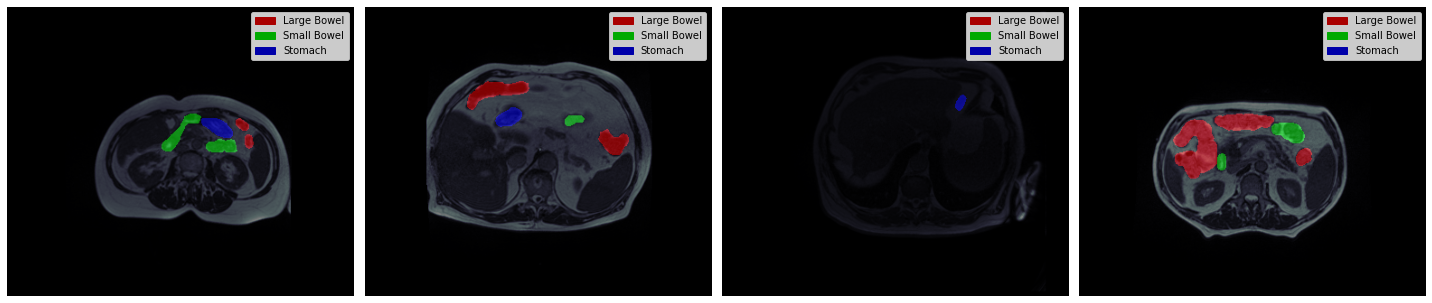

In [7]:
row=1; col=4
plt.figure(figsize=(5*col,5*row))
for i, id_ in enumerate(df[df['empty']==0].sample(frac=1.0)['id'].unique()[:row*col]):
    idf = df[df['id']==id_]
    img = load_img(idf.image_path.iloc[0])
    mask = load_msk(idf.mask_path.iloc[0])
    plt.subplot(row, col, i+1)
    i+=1
    show_img(img, mask=mask)
    plt.tight_layout()

TypeError: Invalid shape (320, 384, 5) for image data

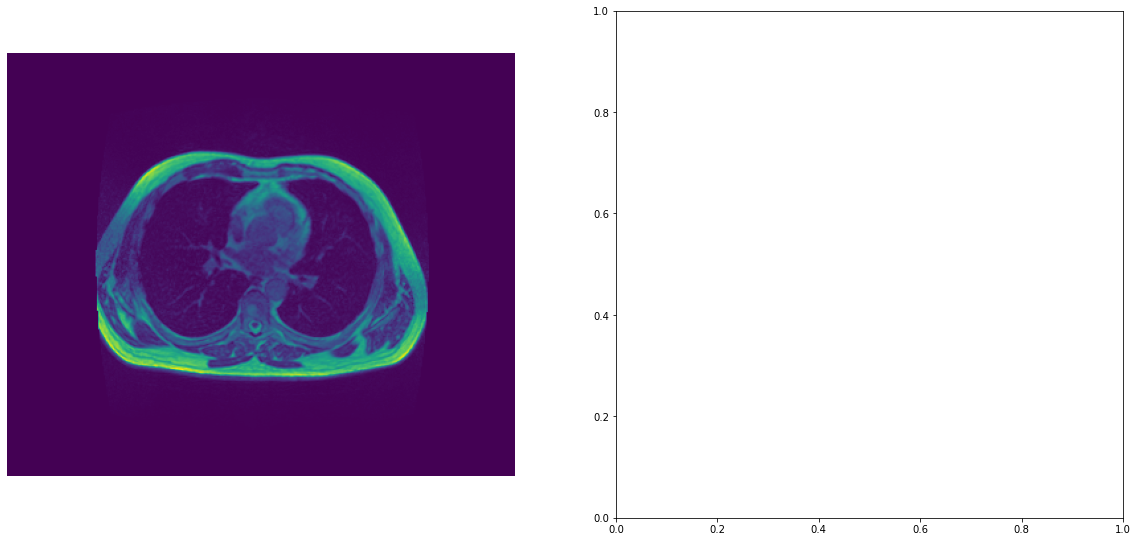

In [10]:
idx = 40

plt.figure(figsize=(20, 10))

plt.subplot(1, 2, 1)
img = load_img(df.image_path[idx]).astype('float32')
img/=img.max()
plt.imshow(img)
plt.axis('off')

# TypeError: Invalid shape (320, 384, 5) for image data
plt.subplot(1, 2, 2)
imgs = load_imgs(df.image_paths[idx]).astype('float32')
imgs/=imgs.max(axis=(0,1))
plt.imshow(imgs)
plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
IMAGE_DIR = '/tmp/images'
MASK_DIR = '/tmp/masks'
!mkdir -p $IMAGE_DIR && mkdir -p $MASK_DIR

def save_mask(id_):
    row = df[df['id']==id_].squeeze()
    
    img_paths = row.image_paths
    imgs = load_imgs(img_paths)
    np.save(f'{IMAGE_DIR}/{id_}.npy', imgs)
    
    msk_path = row.mask_path
    msk = load_msk(msk_path)
    np.save(f'{MASK_DIR}/{id_}.npy', msk)
    
    return

ids = df['id'].unique()
_ = Parallel(n_jobs=-1, backend='threading')(delayed(save_mask)(id_)\
                                             for id_ in tqdm(ids, total=len(ids)))
# 把 images 和 masks 文件夹拷贝到 ~/gi/input/

In [ ]:
plt.figure(figsize=(15, 5))

imgs = np.load(f'{IMAGE_DIR}/case123_day0_slice_0080.npy').astype('float32')
imgs/=imgs.max(axis=(0,1))

plt.subplot(1, 3, 1)
plt.imshow(imgs)

msk = np.load(f'{MASK_DIR}/case123_day0_slice_0080.npy').astype('float32')
msk/=255.0

plt.subplot(1, 3, 2)
plt.imshow(msk)


plt.subplot(1, 3, 3)
plt.imshow(imgs)
plt.imshow(msk, alpha=0.5)

In [ ]:
df.to_csv('train_step1.csv', index=False)
df.head(199)

In [ ]:
import pandas as pd

df = pd.read_csv("/home/yiw/gi/train_step1.csv")
df

In [ ]:
df.height.unique()

In [ ]:

df.width.unique()

In [ ]:
pd.options.display.max_seq_items = 2000
pd.set_option("max_colwidth", None)

df.image_paths[:10]

In [ ]:
df.image_path

In [ ]:
pd.set_option('display.max_rows', None)
df.mask_path[64:99]